In [1]:
import pytz
import plotly.express as px
import seaborn as sns
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
import math
%matplotlib inline

# Data loading

In [2]:
ts15 = pd.read_csv('../../RDN/Load Data (2018-2019)/INRG-load-series.csv', delimiter=',', header=0, index_col=0, parse_dates=True)
ts15

,Load
Date,
2018-01-01 00:00:00,4689.365428
2018-01-01 00:15:00,4653.100916
2018-01-01 00:30:00,4617.549863
2018-01-01 00:45:00,4595.858857
2018-01-01 01:00:00,4574.072846
...,...
2019-12-31 22:45:00,5418.783371
2019-12-31 23:00:00,5355.531827
2019-12-31 23:15:00,5285.912722


# Check for invalid data
No invalid data is detected

In [3]:
print(f"NaNs count: {ts15.isnull().sum().item()}")
print(f"Negative values count: {len(ts15)-ts15[ts15 < 0].isnull().sum().item()}")
print(f"Duplicate indices count: {len(ts15[ts15.index.duplicated()])}")

NaNs count: 0
Negative values count: 0
Duplicate indices count: 0


# Resampling
We create a new load only dataset and change its timestep 60min (hourly).

In [4]:
ts30 = ts15.resample('30T').sum()
ts60 = ts15.resample('60T').sum()
ts60.head()


,Load
Date,
2018-01-01 00:00:00,18555.875064
2018-01-01 01:00:00,18001.483151
2018-01-01 02:00:00,17017.792074
2018-01-01 03:00:00,16187.432017
2018-01-01 04:00:00,15621.660524


We also store the result.

In [5]:
ts60.to_csv('../../RDN/Load Data (2018-2019)/artifacts/load_60min.csv')
ts15.to_csv('../../RDN/Load Data (2018-2019)/artifacts/load_15min.csv')
# ts30.to_csv('../../RDN/Load Data (2018-2019)/artifacts/load_30min.csv')

# Calendar
In this section a calendar is created containing auxiliary info for all unique dates that appear in the core dataset

In [6]:
from preprocessing import *

An extended holiday set is chosen for Portugal that includes days most people have off.

In [7]:
local_tz = pytz.timezone('Europe/Lisbon')
pt_holidays = holidays.Portugal()

The various timestep calendars are created using the imported, calendar related, functions.

15 min Calendar dataset structure:


,datetime,year,month,yearweek,day,hour,minute,second,weekday,monthday,...,month_sin,weekday_sin,monthday_sin,yearday_sin,hour_sin,month_cos,weekday_cos,monthday_cos,yearday_cos,hour_cos
0,2018-01-01 00:00:00,2018,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.000000
1,2018-01-01 00:15:00,2018,1,0,1,0,15,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.000000
2,2018-01-01 00:30:00,2018,1,0,1,0,30,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.000000
3,2018-01-01 00:45:00,2018,1,0,1,0,45,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.000000
4,2018-01-01 01:00:00,2018,1,0,1,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.258819,1.0,1.0,1.0,1.0,0.965926


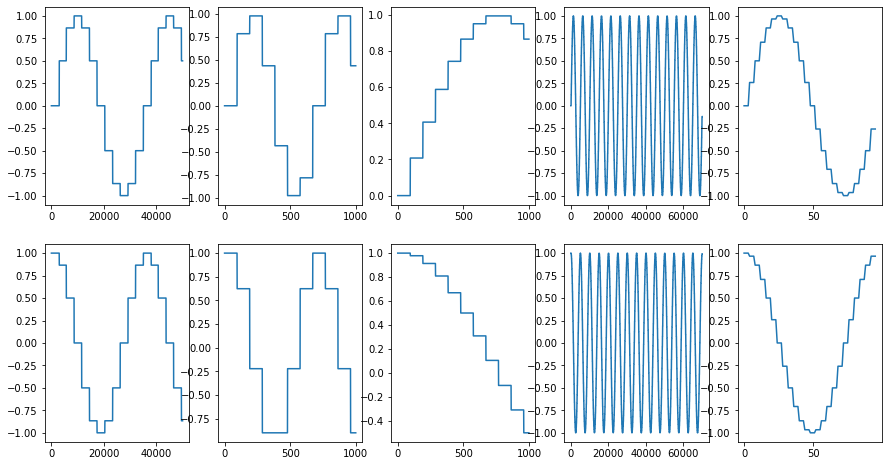

In [8]:
holiday_list = [i for i in ts15.index if i.date() in pt_holidays]
calendar15 = create_calendar(ts15, 15, holiday_list, local_tz)
calendar15 = add_cyclical_time_features(calendar15)
print("15 min Calendar dataset structure:")
calendar15.head()

60 min Calendar dataset structure:


,datetime,year,month,yearweek,day,hour,minute,second,weekday,monthday,...,month_sin,weekday_sin,monthday_sin,yearday_sin,hour_sin,month_cos,weekday_cos,monthday_cos,yearday_cos,hour_cos
0,2018-01-01 00:00:00,2018,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.000000
1,2018-01-01 01:00:00,2018,1,0,1,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.258819,1.0,1.0,1.0,1.0,0.965926
2,2018-01-01 02:00:00,2018,1,0,1,2,0,0,0,0,...,0.0,0.0,0.0,0.0,0.500000,1.0,1.0,1.0,1.0,0.866025
3,2018-01-01 03:00:00,2018,1,0,1,3,0,0,0,0,...,0.0,0.0,0.0,0.0,0.707107,1.0,1.0,1.0,1.0,0.707107
4,2018-01-01 04:00:00,2018,1,0,1,4,0,0,0,0,...,0.0,0.0,0.0,0.0,0.866025,1.0,1.0,1.0,1.0,0.500000


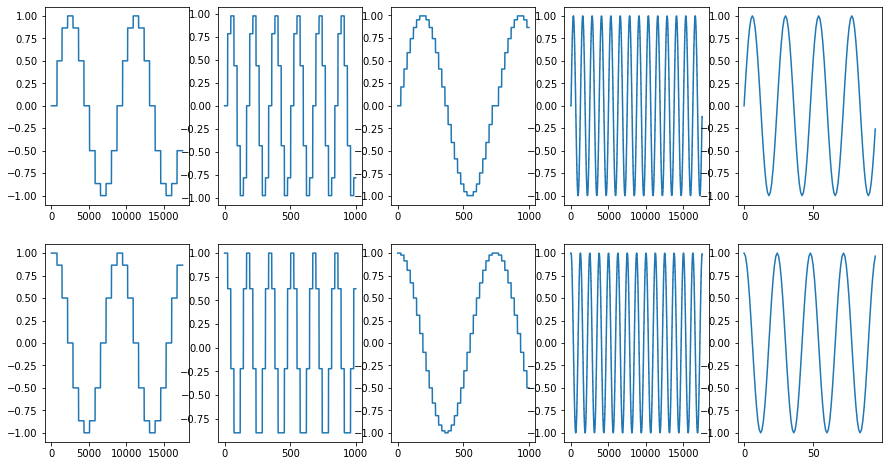

In [9]:
holiday_list = [i for i in ts60.index if i in holidays.PortugalExt()]
calendar60 = create_calendar(ts60, 60, holiday_list, local_tz)
calendar60 = add_cyclical_time_features(calendar60)
print("60 min Calendar dataset structure:")
calendar60.head()

## Store calendar datasets

In [11]:
ts15_plus_time = pd.merge(ts15, calendar15, how='left', left_index=True, right_on='datetime').set_index('datetime')
ts15_plus_time.to_csv("../../RDN/Load Data (2018-2019)/artifacts/timeseries_plus_time_15min.csv")

# ts30_plus_time = pd.merge(ts30, create_calendar(30), how='left', left_index=True, right_on='datetime').set_index('datetime')
# ts30_plus_time.to_csv("../VEOLIA/artifacts/timeseries_plus_time_30min.csv")

ts60_plus_time = pd.merge(ts60, calendar60, how='left', left_index=True, right_on='datetime').set_index('datetime')
ts60_plus_time.to_csv("../../RDN/Load Data (2018-2019)/artifacts/timeseries_plus_time_60min.csv")

time15 = calendar15
time15.to_csv("../../RDN/Load Data (2018-2019)/artifacts/time_15min.csv")

# time30 = create_calendar(30)
# time30.to_csv("../VEOLIA/artifacts/time_30min.csv")

time60 = calendar60
time60.to_csv("../../RDN/Load Data (2018-2019)/artifacts/time_60min.csv")